# Import

In [75]:
using MAT
using LinearAlgebra
using GeneralizedSVD
using Plots
using Images, FileIO
using Noise

# Loading Mat files 

In [76]:
vars = matread("A_y.mat");
A_y = vars["A_y"];
A_y = Matrix(A_y);

# Loading images

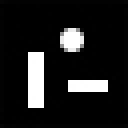

In [77]:
img_path = "org_image.jpg"
org_image = load(img_path)

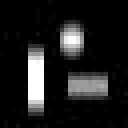

In [78]:
img_path = "A_y_result.jpg"
A_y_result = load(img_path)

In [79]:
n = 1024
Noise_power = 0.05
e = add_gauss(zeros(n,1), Noise_power)
A_y_result_noise = reshape(map(Float64, A_y_result), (32*32,1));

# regulation matrix

In [80]:
L = zeros(n-2,n)
for i in range(1,n-2)
    L[i,i] = -1
    L[i,i+1] = 2
    L[i,i+2] = -1
end
p = n-2;

# Functions

In [81]:
function f(b_hat,lambda_arr,alpha_arr,z_arr,beta,p,eta,delta)
    y = 0 
    for j in range(1,p)
        numerator = (b_hat[j] * lambda_arr[j]^2 - alpha_arr[j] * z_arr[j] * lambda_arr[j]^2)^2
        denominator = (beta * alpha_arr[j]^2 + lambda_arr[j]^2)^2
        y += numerator/denominator
    end
    y = y - (eta*delta)^2
end

function df(b_hat,lambda_arr,alpha_arr,z_arr,beta,p,eta,delta)
    y = 0 
    for j in range(1,p)
        numerator = -2 * (alpha_arr[j]^2) * (b_hat[j] * lambda_arr[j]^2 - alpha_arr[j] * z_arr[j] * lambda_arr[j]^2)^2 
        denominator = (beta * alpha_arr[j]^2 + lambda_arr[j]^2)^3
        y += numerator/denominator
    end
    return y
end

df (generic function with 1 method)

## Beta Finder

In [82]:
function beta_solver(max_iter,beta,epsilon_criterion,beta_max,z_arr)
    for i in range(1,max_iter)
        fx = f(b_hat,lambda_arr,alpha_arr,z_arr,beta,p,eta,delta) 
        if abs(f(b_hat,lambda_arr,alpha_arr,z_arr,beta,p,eta,delta)) < epsilon_criterion
            return beta
        end
        dfx = df(b_hat,lambda_arr,alpha_arr,z_arr,beta,p,eta,delta)
        beta_new = beta - (fx / dfx)
        if beta_new >= beta_max
            return beta
        else
            beta = beta_new
        end
    end
    return beta
end

beta_solver (generic function with 1 method)

# generalized singular value decomposition

In [83]:
F = gsvd(A_y, L);
U = F.U
Sigma = F.C;
V = F.V;
Lambda = F.S;
Y = (F.R*F.Q')';

[A_y; L] ≈ [U*Sigma; V*Lambda] * Y'

true

# initiate the process

In [84]:
x0 = zeros(1024,1);
z_arr = Y' * x0;
b = A_y_result_noise;
b_hat = U' * b;
eta = 1.1
delta = Noise_power * sqrt(n);
norm(A_y * x0 - b)

9.08443624723224

In [85]:
lambda_arr = zeros(p,1);
for i in range(1,p)
    lambda_arr[i] = Lambda[p+1-i,n+1-i];
end
alpha_arr  = zeros(p,1);
for i in range(1,p)
    alpha_arr[i] = Sigma[n+1-i,n+1-i];
end 

In [86]:
beta = 0
max_iter = 40;
max_iter_alg = 40;
epsilon_criterion = 1e-4;
z_criterion = 1e-3;
beta_max = 1000;

# Test two functions

In [87]:
fx = f(b_hat,lambda_arr,alpha_arr,z_arr,beta,p,eta,delta);
dfx = df(b_hat,lambda_arr,alpha_arr,z_arr,beta,p,eta,delta);
fx, dfx

(79.42932669005643, -1.1314060025259224e6)

# Running the Alg

In [88]:
for i in range(1,max_iter_alg)
    beta = beta_solver(max_iter,beta,epsilon_criterion,beta_max,z_arr)
    a = Sigma' * Sigma + (1/beta) * Lambda' * Lambda
    b = Sigma' * b_hat + (1/beta) *  Lambda' * Lambda * z_arr
    new_z = a \ b;
    if norm(new_z - z_arr) < z_criterion 
        z_arr = new_z
        break
    end
    z_arr = new_z
end

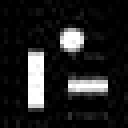

In [89]:
x_reconstructed = Y' \ z_arr;
x_reconstructed = reshape(x_reconstructed, (32,32));
x_reconstructed_image = Gray.(x_reconstructed)